### ¿Por qué usar filtros RC en WDF?

Los filtros RC son estructuras fundamentales en audio digital y electrónica analógica. Su simpleza, eficiencia computacional y comportamiento predecible los hace ideales para:

- Plugins de audio
- Simulación de pedales analógicos
- Procesamiento en tiempo real

En este notebook vamos a:

1. Implementar un filtro RC LowPass de primer orden
2. Implementar un filtro RC HighPass de primer orden
3. Analizar sus respuestas en frecuencia y tiempo
4. Compararlos con las versiones en C++ implementadas en JUCE



### 🔹 2. Filtro RC Low-Pass (Primer Orden)

### Topología

```
Vin — R —+—— Vout  
          |  
          C  
         GND
```


### Función de transferencia

$$
H(s) = \frac{1}{1 + sRC}
$$

La frecuencia de corte es:

$$
f_c = \frac{1}{2\pi RC}
$$



In [1]:
from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
from pywdf.core.circuit import Circuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

class RCLowPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff

        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)

        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.C1)


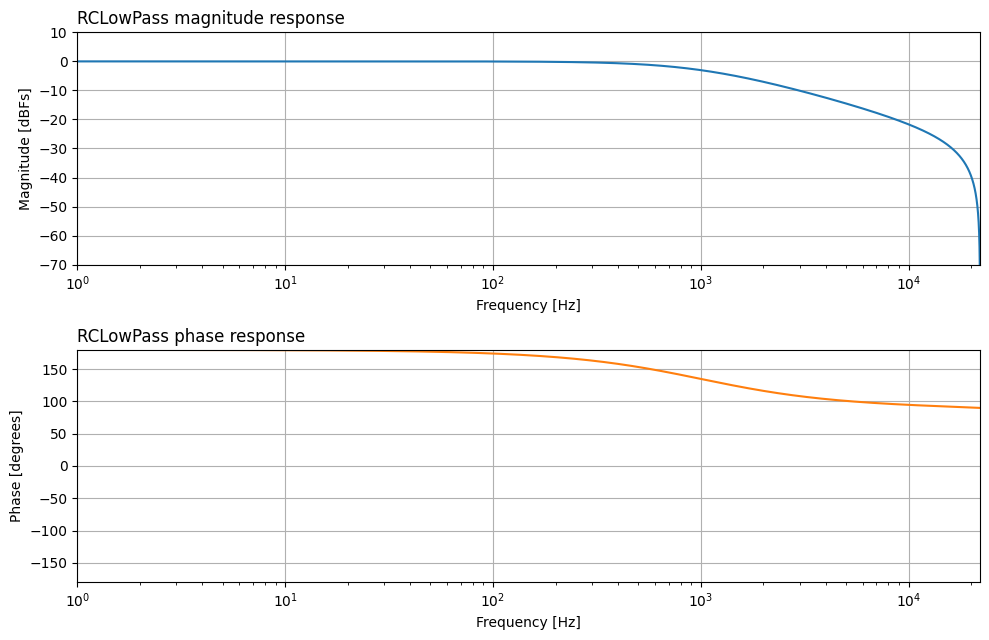

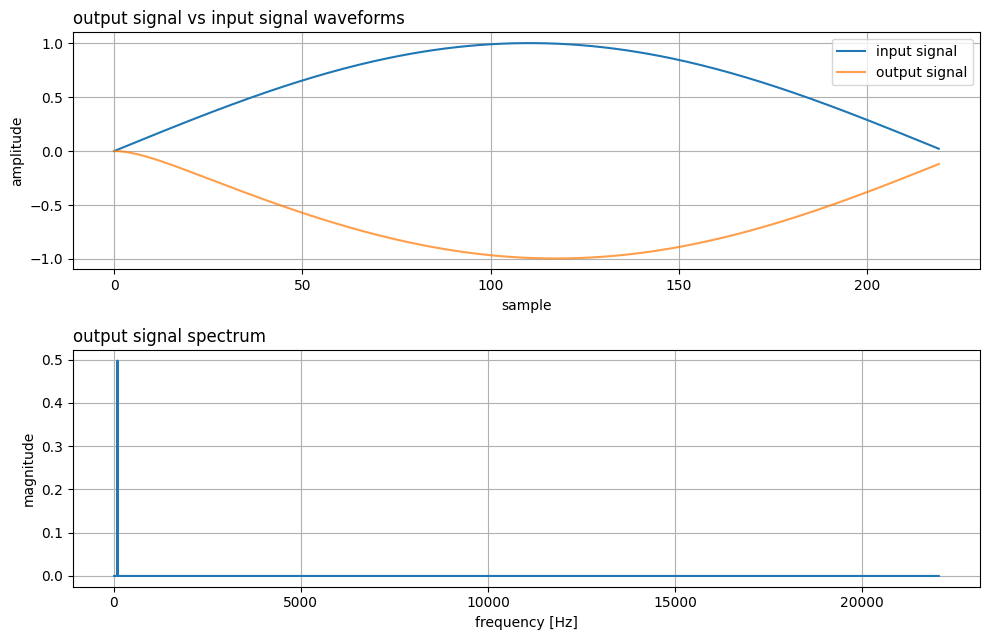

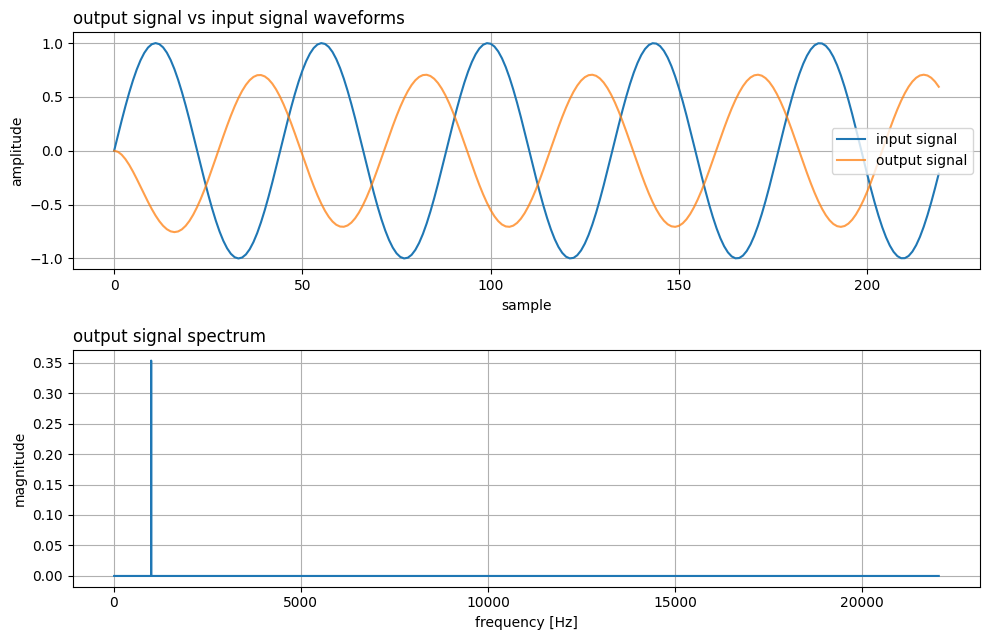

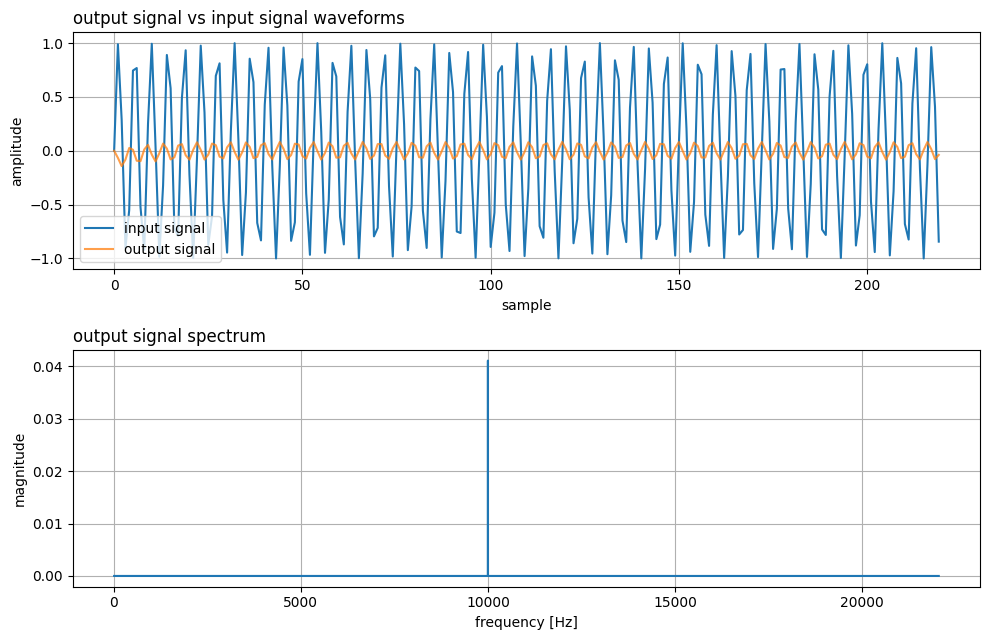

In [2]:
lpf = RCLowPass(fs=44100, cutoff=1000)
lpf.plot_freqz()
lpf.AC_transient_analysis(freq=100, amplitude=1.0, t_ms=5)
lpf.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)
lpf.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)


### Topología

```
Vin — C —+—— Vout  
          |  
          R  
         GND
```


### Función de transferencia

$$
H(s) = \frac{sRC}{1 + sRC}
$$

La frecuencia de corte es:

$$
f_c = \frac{1}{2\pi RC}
$$


In [3]:
class RCHighPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff

        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.C1 = Capacitor(self.C, self.fs)
        self.R1 = Resistor(self.R)

        self.S1 = SeriesAdaptor(self.C1, self.R1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.R1)


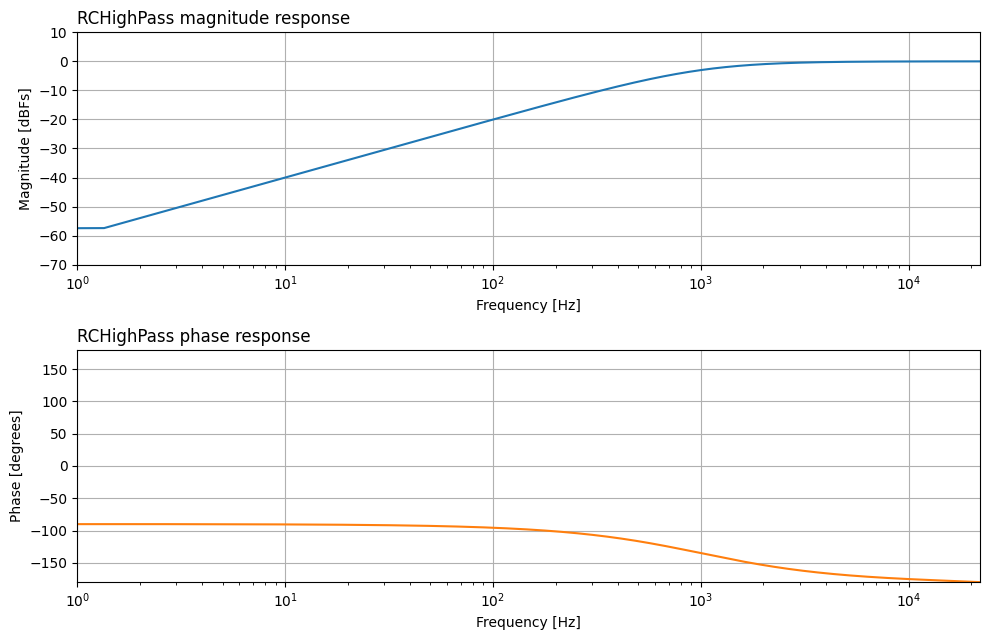

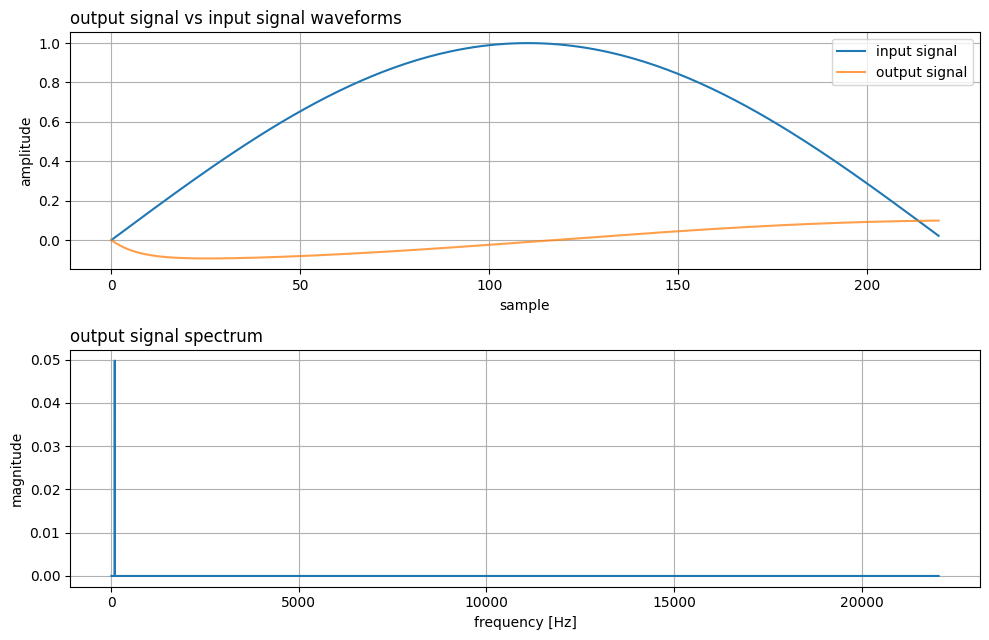

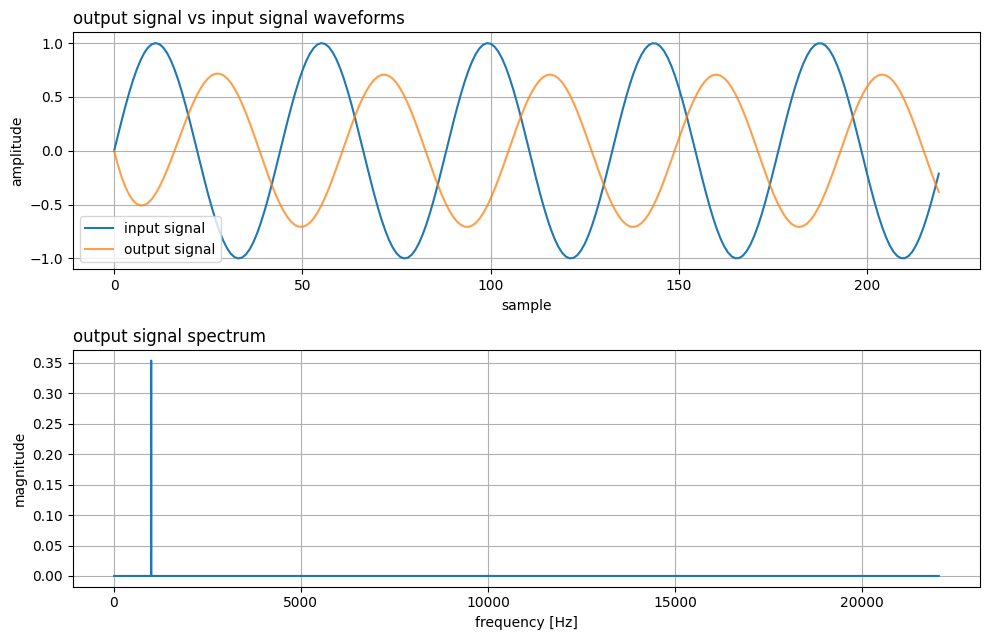

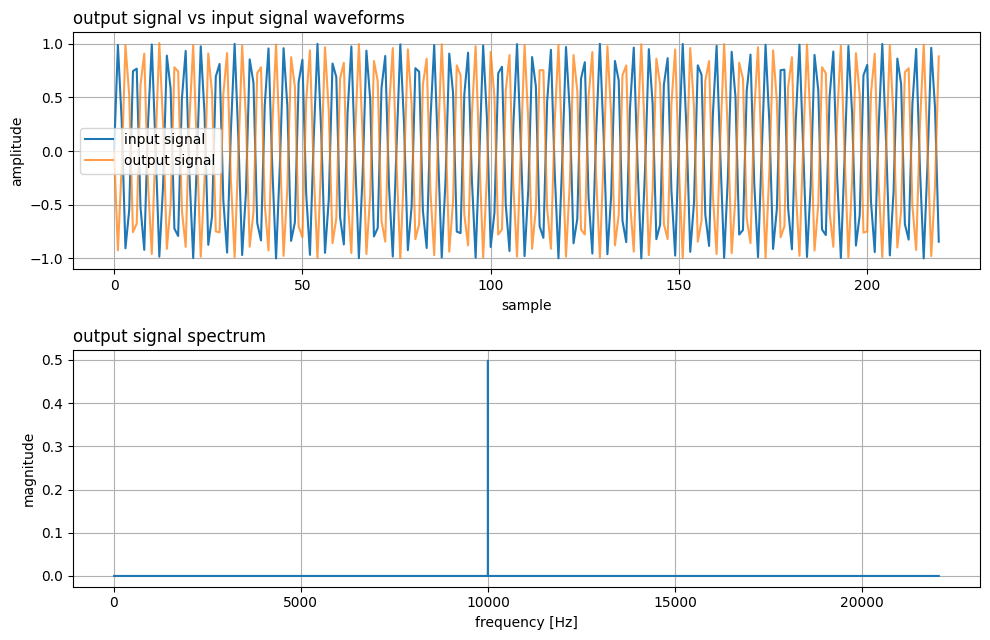

In [4]:
hpf = RCHighPass(fs=44100, cutoff=1000)
hpf.plot_freqz()
hpf.AC_transient_analysis(freq=100, amplitude=1.0, t_ms=5)
hpf.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)
hpf.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)


In [5]:
impulse = lpf.get_impulse_response(delta_dur=1, amp=1)
write("rc_lowpass_1st_order.wav", 44100, impulse.astype(np.float32))

impulse = hpf.get_impulse_response(delta_dur=1, amp=1)
write("rc_highpass_1st_order.wav", 44100, impulse.astype(np.float32))


### `WDFRCLowPass` en JUCE

- Misma topología (R seguido de C)
- Mismo cálculo de R desde la fórmula del corte
- Salida tomada en el capacitor

### `WDFRCHighPass` en JUCE

- Misma topología (C seguido de R)
- Mismo cálculo de R
- Salida tomada en el resistor

✅ Si todo está bien implementado, la respuesta en frecuencia y tiempo de `pywdf` debe coincidir con la de JUCE.


En el siguiente notebook `07_RC_Filtros_RC_SecondOrder.ipynb`:

- Encadenaremos dos filtros RC idénticos
- Analizaremos la pendiente de atenuación (de -20 dB/dec a -40 dB/dec)
- Compararemos con las versiones en cascada de JUCE (`WDFRC2LowPassCascade`, `WDFRC2HighPassCascade`)
